In [1]:
from pandas import Series, DataFrame
import pandas as pd
from patsy import dmatrices
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics, tree
from xgboost import XGBClassifier
import xgboost as xgb
from sklearn.metrics import accuracy_score, confusion_matrix

# Reading in Data

In [41]:
df = pd.read_csv('birthrate.csv.gz')

In [42]:
df.columns

Index(['YEAR', 'HOUSEHOLD_INCOME', 'CHILDREN_STATUS', 'NUMBER_OF_CHILDREN',
       'PERSON_WEIGHT', 'AGE', 'CLASS_OF_WORKER', 'GAVE_BIRTH_12MO',
       'MARITAL_STATUS', 'NUM_TIMES_MARRIED', 'YEAR_LAST_MARRIED',
       'MOBILITY_STATUS', 'GRADE_LEVEL_ATTENDING', 'EDUCATION', 'SEX',
       'WHEN_LAST_WORKED', 'EMPLOYMENT_STATUS', 'HEALTH_INSURANCE',
       'INCOME_TOTAL'],
      dtype='object')

===========================EDA ====================================

In [4]:
df.shape

(38984, 19)

In [5]:
df['MARITAL_STATUS'].value_counts()

,count
MARITAL_STATUS,
Married,18856
Never married or under 15 years old,15069
Divorced,3826
Separated,749
Widowed,483


In [6]:
df['NUMBER_OF_CHILDREN'].value_counts()

,count
NUMBER_OF_CHILDREN,
0 children present,20049
1 child present,7522
2,6926
3,2968
4,1030
5,321
6,108
7,42
8,11


In [7]:
# convert the number of children strings to numbers
children_map = {'0 children present': 0,
                '1 child present': 1,
                '2': 2,
                '3': 3,
                '4': 4,
                '5': 5,
                '6': 6,
                '7': 7,
                '8': 8,
                '9+': 9
               }
df['number_of_children_int'] = df['NUMBER_OF_CHILDREN'].map(children_map)

In [8]:
df['number_of_children_int'].value_counts()

,count
number_of_children_int,
0.0,20049
1.0,7522
2.0,6926
3.0,2968
4.0,1030
5.0,321
6.0,108
7.0,42
8.0,11


In [9]:
children_by_marital_status = df.groupby('MARITAL_STATUS').agg(total_children=('number_of_children_int', 'sum')).sort_values('total_children', ascending=False)
children_by_marital_status

,total_children
MARITAL_STATUS,
Married,26017.0
Never married or under 15 years old,5738.0
Divorced,3843.0
Separated,992.0
Widowed,497.0


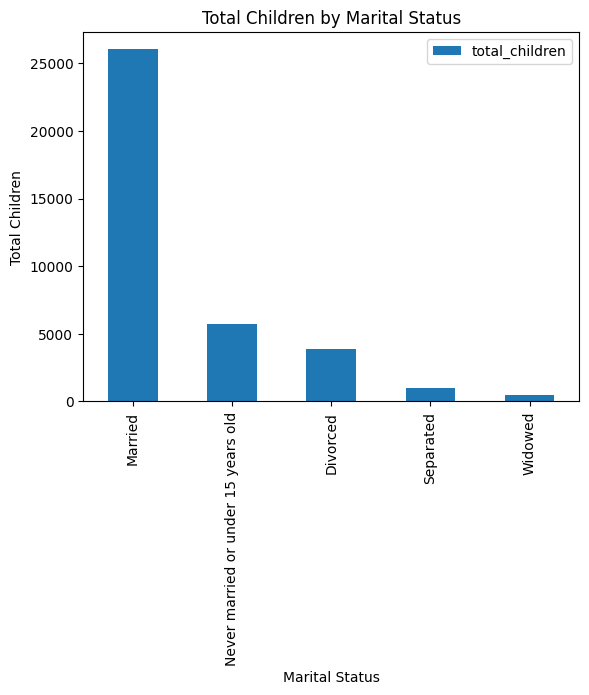

In [10]:
children_by_marital_status.plot(kind='bar')
plt.xlabel('Marital Status')
plt.ylabel('Total Children')
plt.title('Total Children by Marital Status')
plt.show()

In [11]:
children_count = df['NUMBER_OF_CHILDREN'].value_counts()
children_count

,count
NUMBER_OF_CHILDREN,
0 children present,20049
1 child present,7522
2,6926
3,2968
4,1030
5,321
6,108
7,42
8,11


In [12]:
four_plus = children_count.iloc[4:].sum()
four_plus

np.int64(1518)

In [13]:
children_pie = children_count.iloc[:4]
print(children_pie)
children_pie["4+"] = four_plus
print(children_pie)

NUMBER_OF_CHILDREN
0 children present    20049
1 child present        7522
2                      6926
3                      2968
Name: count, dtype: int64
NUMBER_OF_CHILDREN
0 children present    20049
1 child present        7522
2                      6926
3                      2968
4+                     1518
Name: count, dtype: int64


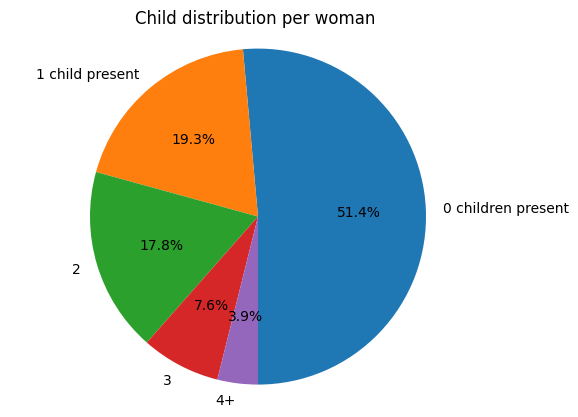

In [14]:
plt.pie(children_pie.values,
        labels=children_pie.index,
        autopct='%1.1f%%', startangle=270)
plt.title('Child distribution per woman ')
plt.axis('equal')  # Ensures pie is drawn as a circle
plt.show()

In [15]:
df['EDUCATION'].value_counts()

,count
EDUCATION,
Bachelor's degree,8036
Regular high school diploma,7505
"1 or more years of college credit, no degree",5611
Associate's degree,3678
Master's degree,3661
"Some college, but less than 1 year",2743
Grade 11,1577
GED or alternative credential,1424
Grade 10,1109


In [16]:
# Filter out women with 2+ children


===========================EDA FINISHED ====================================

# Feature Engineering (X)

In [17]:
# 1 = have married before, 0 = have never married
df['ever_married'] = (df['MARITAL_STATUS'] != 'Never married or under 15 years old').astype(int)

# convert the number of times married into numbers
marriage_map = {'N/A (age less than 15 years; never married)': 0,
                'One time': 1,
                'Two times': 2,
                'Three or more times': 3}
df['num_times_married'] = df['NUM_TIMES_MARRIED'].map(marriage_map)

# calculate years since marriage
df['years_since_marriage'] = 2023 - pd.to_numeric(df['YEAR_LAST_MARRIED'], errors='coerce')
df['years_since_marriage'] = df['years_since_marriage'].fillna(0)

# 1 = moved somewhere last year, 0 = didn't move anywhere
df['moved_last_year'] = df['MOBILITY_STATUS'].apply(lambda x: 0 if x=='Yes, same house (nonmovers)' else 1)

# calculate number of years of education
education_map = {
    'No schooling completed': 0, 'Nursery school, preschool': 0, 'Kindergarten': 0,
    'Grade 1': 1, 'Grade 2': 2, 'Grade 3': 3, 'Grade 4': 4, 'Grade 5': 5, 'Grade 6': 6, 'Grade 7': 7, 'Grade 8': 8, 'Grade 9': 9, 'Grade 10': 10,
    'Grade 11': 11, '12th grade - no diploma': 12, 'Regular high school diploma': 12, 'GED or alternative credential': 12,
    'Some college, but less than 1 year': 13, '1 or more years of college credit, no degree': 14,
    "Associate's degree": 15, "Bachelor's degree": 16, "Master's degree": 18, "Professional degree beyond a bachelor's degree": 19, "Doctorate degree": 20 }
df['education_years'] = df['EDUCATION'].map(education_map)

# 1 = has medical insurance, 0 = no medical insurance
df['has_insurance'] = (df['HEALTH_INSURANCE'] == 'With health insurance coverage').astype(int)

# 1 = employed of some forms, 0 = not employed
employed_group = ['Civilian employed, at work', 'Civilian employed, with a job but not at work', 'Armed forces, at work', 'Armed forces, with a job but not at work' ]
df['employed'] = df['EMPLOYMENT_STATUS'].apply(lambda x: 1 if x in employed_group else 0)

# 1 = give birth for the past year, 0 = no birth past year
df['gave_birth_12mo'] = df['GAVE_BIRTH_12MO'].map(lambda x: 1 if x == 'Yes' else 0)

# Create Target Variable (y = above_2child)

In [18]:
df['above_2child'] = df['NUMBER_OF_CHILDREN'].map(
    lambda x: 0 if x in ['0 children present', '1 child present'] else 1)

In [19]:
df['above_2child'].value_counts(normalize=True)   #30% of the data have over 2 children

,proportion
above_2child,
0,0.707239
1,0.292761


In [20]:
df.columns

Index(['YEAR', 'HOUSEHOLD_INCOME', 'CHILDREN_STATUS', 'NUMBER_OF_CHILDREN',
       'PERSON_WEIGHT', 'AGE', 'CLASS_OF_WORKER', 'GAVE_BIRTH_12MO',
       'MARITAL_STATUS', 'NUM_TIMES_MARRIED', 'YEAR_LAST_MARRIED',
       'MOBILITY_STATUS', 'GRADE_LEVEL_ATTENDING', 'EDUCATION', 'SEX',
       'WHEN_LAST_WORKED', 'EMPLOYMENT_STATUS', 'HEALTH_INSURANCE',
       'INCOME_TOTAL', 'number_of_children_int', 'ever_married',
       'num_times_married', 'years_since_marriage', 'moved_last_year',
       'education_years', 'has_insurance', 'employed', 'gave_birth_12mo',
       'above_2child'],
      dtype='object')

# Logistic Regression

In [21]:
formula = 'above_2child ~ 0 + PERSON_WEIGHT + AGE + ever_married + num_times_married + years_since_marriage' + \
          ' + moved_last_year + education_years + has_insurance + employed + HOUSEHOLD_INCOME + gave_birth_12mo'

In [22]:
Y, X = dmatrices(formula, df, return_type='dataframe')
y = Y['above_2child'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

model = LogisticRegression(max_iter=10000)
result = model.fit(X_train, y_train)

prediction_train = model.predict(X_train)
print("Train Accuracy:", metrics.accuracy_score(y_train, prediction_train))

prediction = model.predict(X_test)
print("Test Accuracy:", metrics.accuracy_score(y_test, prediction))

Train Accuracy: 0.7112650249193785
Test Accuracy: 0.7111586147926464


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [23]:
actual_iterations = model.n_iter_
actual_iterations

array([10000], dtype=int32)

In [24]:
weights = Series(model.coef_[0],
                 index=X.columns.values)
weights.sort_values(ascending=False)

,0
ever_married,2.339292e+00
gave_birth_12mo,9.794305e-01
AGE,1.333201e-02
PERSON_WEIGHT,9.855925e-04
HOUSEHOLD_INCOME,4.559925e-07
years_since_marriage,-1.266943e-02
education_years,-2.056979e-02
has_insurance,-2.446026e-02
employed,-1.897246e-01
moved_last_year,-4.201212e-01


# XGBoost Classifier --> better test accuracy

In [25]:
Y, X = dmatrices(formula, df, return_type='dataframe')
y = Y['above_2child'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

xgb_model = XGBClassifier(n_estimators=200,
                          learning_rate=0.05,
                          max_depth=4)
xgb_model.fit(X_train, y_train)

train_preds = xgb_model.predict(X_train)
test_preds = xgb_model.predict(X_test)
print("Train Accuracy:", accuracy_score(y_train, train_preds))
print("Test Accuracy:", accuracy_score(y_test, test_preds))

#feature importance
importances = xgb_model.feature_importances_
importance_df = pd.DataFrame({'Feature': X.columns,
                              'Importance': importances}).sort_values(by='Importance', ascending=False)
print(importance_df)

Train Accuracy: 0.783311345646438
Test Accuracy: 0.7718683197947841
                 Feature  Importance
4   years_since_marriage    0.307522
1                    AGE    0.233036
2           ever_married    0.102038
10       gave_birth_12mo    0.091968
6        education_years    0.067486
8               employed    0.053227
3      num_times_married    0.048148
9       HOUSEHOLD_INCOME    0.035536
5        moved_last_year    0.030963
7          has_insurance    0.017052
0          PERSON_WEIGHT    0.013022


In [26]:
print("Feature Coefficients:")
print(xgb_model.get_booster().get_dump()[0])

Feature Coefficients:
0:[years_since_marriage<4] yes=1,no=2,missing=2
	1:[AGE<27] yes=3,no=4,missing=4
		3:[gave_birth_12mo<1] yes=7,no=8,missing=8
			7:[AGE<24] yes=15,no=16,missing=16
				15:leaf=-0.0688483045
				16:leaf=-0.054070022
			8:[AGE<21] yes=17,no=18,missing=18
				17:leaf=-0.0393472351
				18:leaf=0.0196866132
		4:[education_years<16] yes=9,no=10,missing=10
			9:[AGE<47] yes=19,no=20,missing=20
				19:leaf=0.00432677008
				20:leaf=-0.0333059542
			10:[num_times_married<2] yes=21,no=22,missing=22
				21:leaf=-0.0486493744
				22:leaf=0.00488385139
	2:[AGE<47] yes=5,no=6,missing=6
		5:[years_since_marriage<8] yes=11,no=12,missing=12
			11:[gave_birth_12mo<1] yes=23,no=24,missing=24
				23:leaf=0.0230839718
				24:leaf=0.0875573605
			12:[AGE<44] yes=25,no=26,missing=26
				25:leaf=0.084438473
				26:leaf=0.0548806973
		6:[AGE<51] yes=13,no=14,missing=14
			13:[HOUSEHOLD_INCOME<94000] yes=27,no=28,missing=28
				27:leaf=-0.0109430617
				28:leaf=0.024983786
			14:[HOUSEHOLD

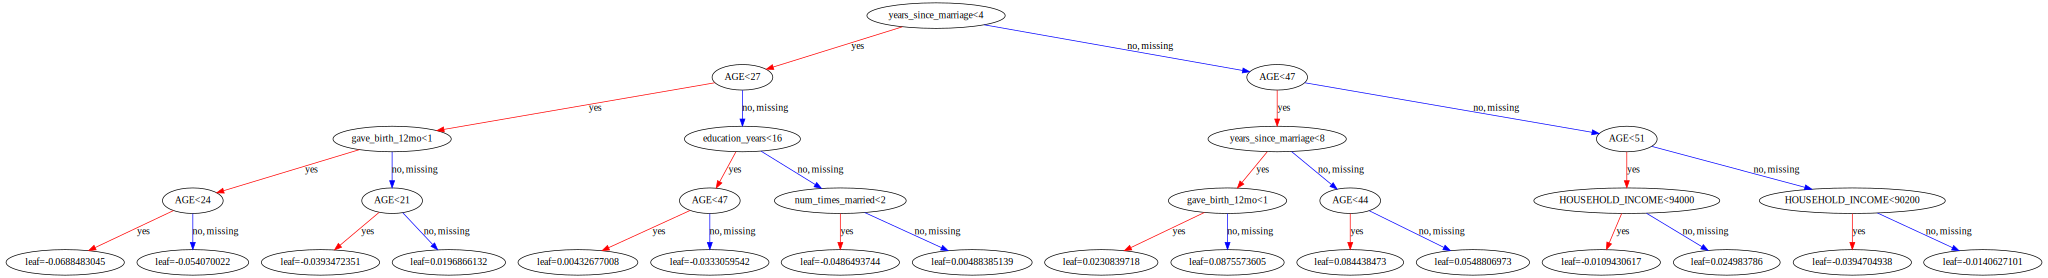

In [37]:
import graphviz
import xgboost as xgb

# Get the tree dump in dot format
tree_dump = xgb_model.get_booster().get_dump(dump_format='dot')[0]

# Create a graphviz Source object from the dot string
graphviz.Source(tree_dump)

# Model Evaluation (XGBoost)

In [38]:
confusion_matrix(y_test, test_preds)

array([[7210, 1090],
       [1578, 1817]])

# Cross-Validation to find optimal n_estimators & max_depth

### n_estimators = 200, max_depth = 4

Text(0, 0.5, 'Test accuracy')

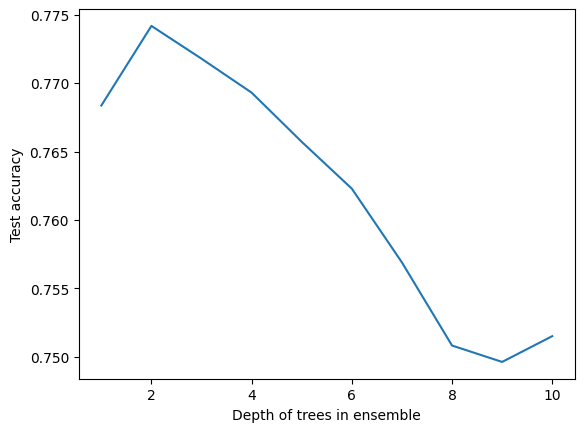

In [39]:
scores = {}
for depth in range(1, 11):
    model = XGBClassifier(n_estimators=200,
                          max_depth=depth,
                          random_state=1)
    model.fit(X_train, y_train)
    prediction_test = model.predict(X_test)
    accuracy_test = metrics.accuracy_score(y_test, prediction_test)
    scores[depth] = accuracy_test
Series(scores).sort_index().plot()
plt.xlabel('Depth of trees in ensemble')
plt.ylabel('Test accuracy')

Text(0, 0.5, 'Test accuracy')

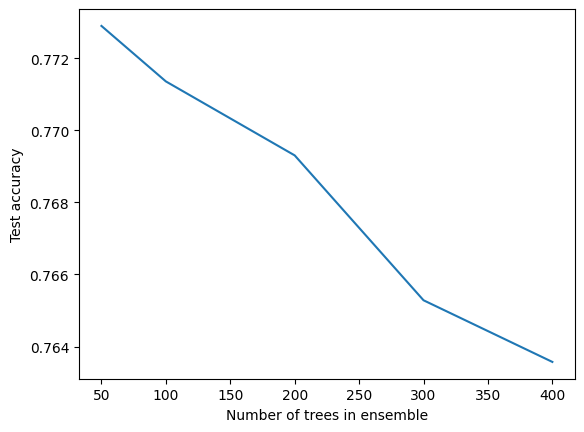

In [40]:
scores = {}
for num_trees in [50, 100, 200, 300, 400]:
    model = XGBClassifier(n_estimators=num_trees,
                          max_depth=4,
                          random_state=1)
    model.fit(X_train, y_train)
    prediction_test = model.predict(X_test)
    accuracy_test = metrics.accuracy_score(y_test, prediction_test)
    scores[num_trees] = accuracy_test
Series(scores).sort_index().plot()
plt.xlabel('Number of trees in ensemble')
plt.ylabel('Test accuracy')